In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [4]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model, note that there are many typos in Kardy's paper for this eq'n
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, t, u, v, w = x_y_z_t_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v, 
            f1 * z + f2 * t + f3 *u + f4 * z * v + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * w + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    

# Cart on a pendulum
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, 
            ((M + m) * g * np.sin(w) - F * np.cos(w) - m * L1 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 * (M + m * np.sin(w) ** 2)),
            (m * L1 * np.sin(w) * y ** 2 + F - m * g * np.sin(w) * np.cos(
                w)) / (M + m * np.sin(w) ** 2)]


# Control input models for kinematic single-track model
def f_steer(x, u1, min_sangle=-0.91, max_sangle=0.91, 
                   min_svel=-0.4, max_svel=0.4, 
                   min_vel=-13.9, max_vel=45.8,
                   switch_vel=4.755, amaz=11.5):
    return 0
    

def f_acc(y, u2, min_sangle=-0.91, max_sangle=0.91, 
                 min_svel=-0.4, max_svel=0.4, 
                 min_vel=-13.9, max_vel=45.8,
                 switch_vel=4.755, amaz=11.5):
    return 0
    

# CommonRoad kinematic single-track model
def kinematic_model(v_w_x_y_z, t0, u1, u2, amax=11.5, lwb=2.391):
    v, w, x, y, z = v_w_x_y_z
    return [y * cos(z),
            y * sin(z),
           f_steer(x, u1),
           f_acc(y, u2),
           y * np.tan(x) / lwb]


# Infamous double pendulum problem (frictionless if k1=k2=0)
def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_indices[k]) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0_train, t)
x0_test = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0_test, t)

# define hyperparameters
threshold = 1e-3

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-04   1.00e+00   1.18e+05   1.00e-01   1.02e-03s
 200   2.6881e-02   7.16e-03   4.56e-06   3.76e-03   5.78e-03s
 400   2.6031e-02   3.63e-03   2.41

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-04   2.17e+02   5.44e+06   1.00e-01   6.49e-04s
 150   1.4007e-03   1.14e-03   2.20e-06   2.77e-03   4.79e-03s

status:               solved
solution polis

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f1c473c7450>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.001))

[1]
0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
(10, 1) du[0]


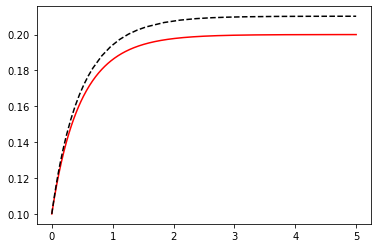

In [6]:
coef_indices = np.arange(1, r + 1)
print(coef_indices)
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)
print(coefs.shape, feature_names[coef_indices[0]])

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [7]:
# define parameters
r = 4
dt = 0.025
T = 50
t = np.arange(0, T + dt, dt)

x0_train = [0.3, 0, 1, 0]
x_train = integrate.odeint(pendulum_on_cart_deriv, x0_train, t)
x0_test = [np.pi, 0, 0, 0]
x_test = integrate.odeint(pendulum_on_cart_deriv, x0_test, t)

# define hyperparameters
threshold = 1e7

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
print(model.get_feature_names())
print(np.shape(model.get_feature_names()))
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))

(1999, 4)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   8.00e+00   1.00e+13   1.00e-01   1.13e-01s
 125   1.2982e+03   6.64e-07   1.56e+01   2.93e+02   5.87e-01s

status:               solved


 200   4.8133e+06   1.60e-03   5.89e+02   5.48e-01   6.36e-01s
 400   4.8245e+06   7.92e-04   1.94e+02   5.48e-01   9.87e-01s
 475   4.8338e+06   6.22e-04   6.80e+01   5.48e-01   1.12e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 475
optimal objective:    4833791.1357
run time:             1.24e+00s
optimal rho estimate: 1.47e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 

 175   8.2422e+05   6.24e-04   8.62e+01   1.32e+00   5.87e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 175
optimal objective:    824222.5681
run time:             6.97e-01s
optimal rho estimate: 5.21e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, p

 200   3.6974e+05   4.70e-05   1.14e+03   1.16e+01   8.09e-01s
 350   3.7055e+05   3.78e-06   2.28e+01   1.16e+01   1.07e+00s
plsh   3.7058e+05   2.74e-13   4.47e-04   --------   1.18e+00s

status:               solved
solution polish:      successful
number of iterations: 350
optimal objective:    370581.5592
run time:             1.18e+00s
optimal rho estimate: 8.63e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100

 200   3.7041e+06   5.32e-05   7.93e+01   1.15e+01   5.51e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 200
optimal objective:    3704084.6264
run time:             6.61e-01s
optimal rho estimate: 1.50e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, 

3600   4.0212e+10   2.41e-03   8.76e+02   3.64e-03   6.52e+00s
3800   4.0212e+10   2.44e-03   8.50e+02   3.64e-03   6.87e+00s
4000   4.0211e+10   2.45e-03   8.25e+02   3.64e-03   7.22e+00s
4200   4.0211e+10   2.43e-03   8.01e+02   3.64e-03   7.57e+00s
4400   4.0211e+10   2.40e-03   7.77e+02   3.64e-03   7.93e+00s
4600   4.0211e+10   2.37e-03   7.54e+02   3.64e-03   8.28e+00s
4800   4.0211e+10   2.32e-03   7.32e+02   3.64e-03   8.62e+00s
5000   4.0211e+10   2.27e-03   7.10e+02   3.64e-03   8.98e+00s
5200   4.0211e+10   2.21e-03   6.89e+02   3.64e-03   9.33e+00s
5400   4.0211e+10   2.16e-03   6.69e+02   3.64e-03   9.68e+00s
5600   4.0211e+10   2.10e-03   6.49e+02   3.64e-03   1.00e+01s
5800   4.0211e+10   2.04e-03   6.30e+02   3.64e-03   1.04e+01s
6000   4.0211e+10   1.99e-03   6.11e+02   3.64e-03   1.07e+01s
6200   4.0211e+10   1.93e-03   5.93e+02   3.64e-03   1.11e+01s
6400   4.0211e+10   1.88e-03   5.75e+02   3.64e-03   1.14e+01s
6600   4.0211e+10   1.82e-03   5.58e+02   3.64e-03   1.

/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   4.74e+05   9.25e+16   1.00e-01   1.13e-01s
  75   4.1068e+09   1.11e-01   3.99e+01   1.75e-03   3.30e-01s

status:               solved
solution p

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   2.36e+04   2.61e+16   1.00e-01   1.15e-01s
 100   2.6112e+08   5.40e-02   1.94e+01   4.13e-03   3.83e-01s

status:               solved
solution p

 150   1.2477e+04   1.98e-07   1.74e+00   1.44e+01   7.21e-01s
plsh   1.2475e+04   3.07e-13   1.42e-04   --------   8.28e-01s

status:               solved
solution polish:      successful
number of iterations: 150
optimal objective:    12475.0429
run time:             8.28e-01s
optimal rho estimate: 2.06e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scal

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   8.00e+00   8.65e+11   1.00e-01   1.18e-01s
  75   1.1221e+04   5.85e-05   3.08e-01   2.20e+01   3.40e-01s
plsh   1.1651e+04   6.29e-08   8.79e-02 

  75   8.0518e+04   2.93e-05   8.63e-01   2.17e+01   3.32e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 75
optimal objective:    80518.4901
run time:             4.42e-01s
optimal rho estimate: 7.33e+03

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, pol

 200   1.0350e+07   1.05e-03   1.16e+02   4.76e-01   6.38e-01s
 250   1.0354e+07   9.18e-04   9.32e+01   4.76e-01   7.25e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 250
optimal objective:    10354265.0104
run time:             8.33e-01s
optimal rho estimate: 1.32e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
         

 200   7.3643e+07   1.68e-04   1.16e+02   6.02e+00   5.42e-01s
 250   7.3644e+07   1.38e-04   9.43e+01   6.02e+00   6.29e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 250
optimal objective:    73643888.9301
run time:             7.38e-01s
optimal rho estimate: 1.24e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
         

  75   1.2301e+04   2.70e-05   9.11e-02   8.99e+00   3.30e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 75
optimal objective:    12301.0215
run time:             4.41e-01s
optimal rho estimate: 7.35e+03

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, pol

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   8.00e+00   2.48e+12   1.00e-01   1.13e-01s
 125   1.1910e+04   1.02e-07   2.96e+01   1.62e+02   5.95e-01s
plsh   1.1909e+04   9.90e-15   7.72e-06 

  75   8.0453e+04   2.95e-05   4.58e-01   2.02e+01   3.29e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 75
optimal objective:    80453.0211
run time:             4.39e-01s
optimal rho estimate: 8.16e+03

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, pol

 100   1.0289e+07   1.07e-03   8.51e+01   5.52e-01   4.63e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 100
optimal objective:    10288912.3257
run time:             5.74e-01s
optimal rho estimate: 1.89e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on,

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   7.39e+02   9.30e+12   1.00e-01   1.13e-01s
 100   1.0359e+07   6.05e-04   6.62e+01   6.20e-01   4.66e-01s

status:               solved
solution p

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   2.54e+01   3.56e+13   1.00e-01   1.13e-01s
  75   5.9918e+04   2.23e-04   2.59e+00   3.17e+01   3.29e-01s

status:               solved
solution p

 100   9.7879e+03   5.35e-07   6.86e+01   1.33e+04   4.73e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 100
optimal objective:    9787.9202
run time:             5.87e-01s
optimal rho estimate: 1.50e+04

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, pol

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   2.61e+01   4.63e+13   1.00e-01   1.17e-01s
 150   1.4654e+05   2.41e-05   9.55e+01   7.14e+00   6.63e-01s
plsh   1.4681e+05   3.85e-14   4.59e-05 

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   6.98e+02   2.56e+14   1.00e-01   1.13e-01s
 175   7.8299e+06   2.40e-03   9.08e+01   2.69e-01   5.97e-01s

status:               solved
solution p

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   7.35e+02   3.23e+14   1.00e-01   1.13e-01s
 200   8.5113e+06   1.72e-03   1.28e+02   5.30e-01   5.46e-01s
 275   8.5168e+06   1.36e-03   9.11e+01 

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   1.34e+01   3.10e+12   1.00e-01   1.13e-01s
 125   4.0440e+04   1.65e-05   1.24e+01   3.21e+01   4.16e-01s

status:               solved
solution p

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   8.00e+00   4.18e+11   1.00e-01   1.13e-01s
 200   3.4581e+03   3.05e-09   1.07e+00   4.99e+02   7.23e-01s

status:               solved
solution p

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   1.33e+01   1.21e+11   1.00e-01   1.14e-01s
  75   2.0117e+04   3.90e-06   1.12e-01   1.92e+01   3.35e-01s
plsh   2.0120e+04   1.62e-08   6.42e-02 

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   3.75e+02   2.53e+13   1.00e-01   1.15e-01s
 200   7.3852e+06   1.99e-03   1.45e+02   3.66e-01   6.42e-01s
 400   7.4313e+06   4.16e-04   1.13e+02 

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+10   3.63e+02   1.03e+13   1.00e-01   1.15e-01s
 200   2.0883e+07   5.29e-04   1.59e+04   5.22e+00   6.40e-01s
 325   2.0894e+07   4.05e-05   6.77e+01 

In [8]:
nonzero_coefs = (sindy_opt.coef_)[sindy_opt.coef_ > 1e-5]
print(nonzero_coefs)

[1.36148145e-04 5.45162103e-05 2.87345738e-05 ... 1.28827242e-04
 1.43531062e-05 4.62194265e-01]


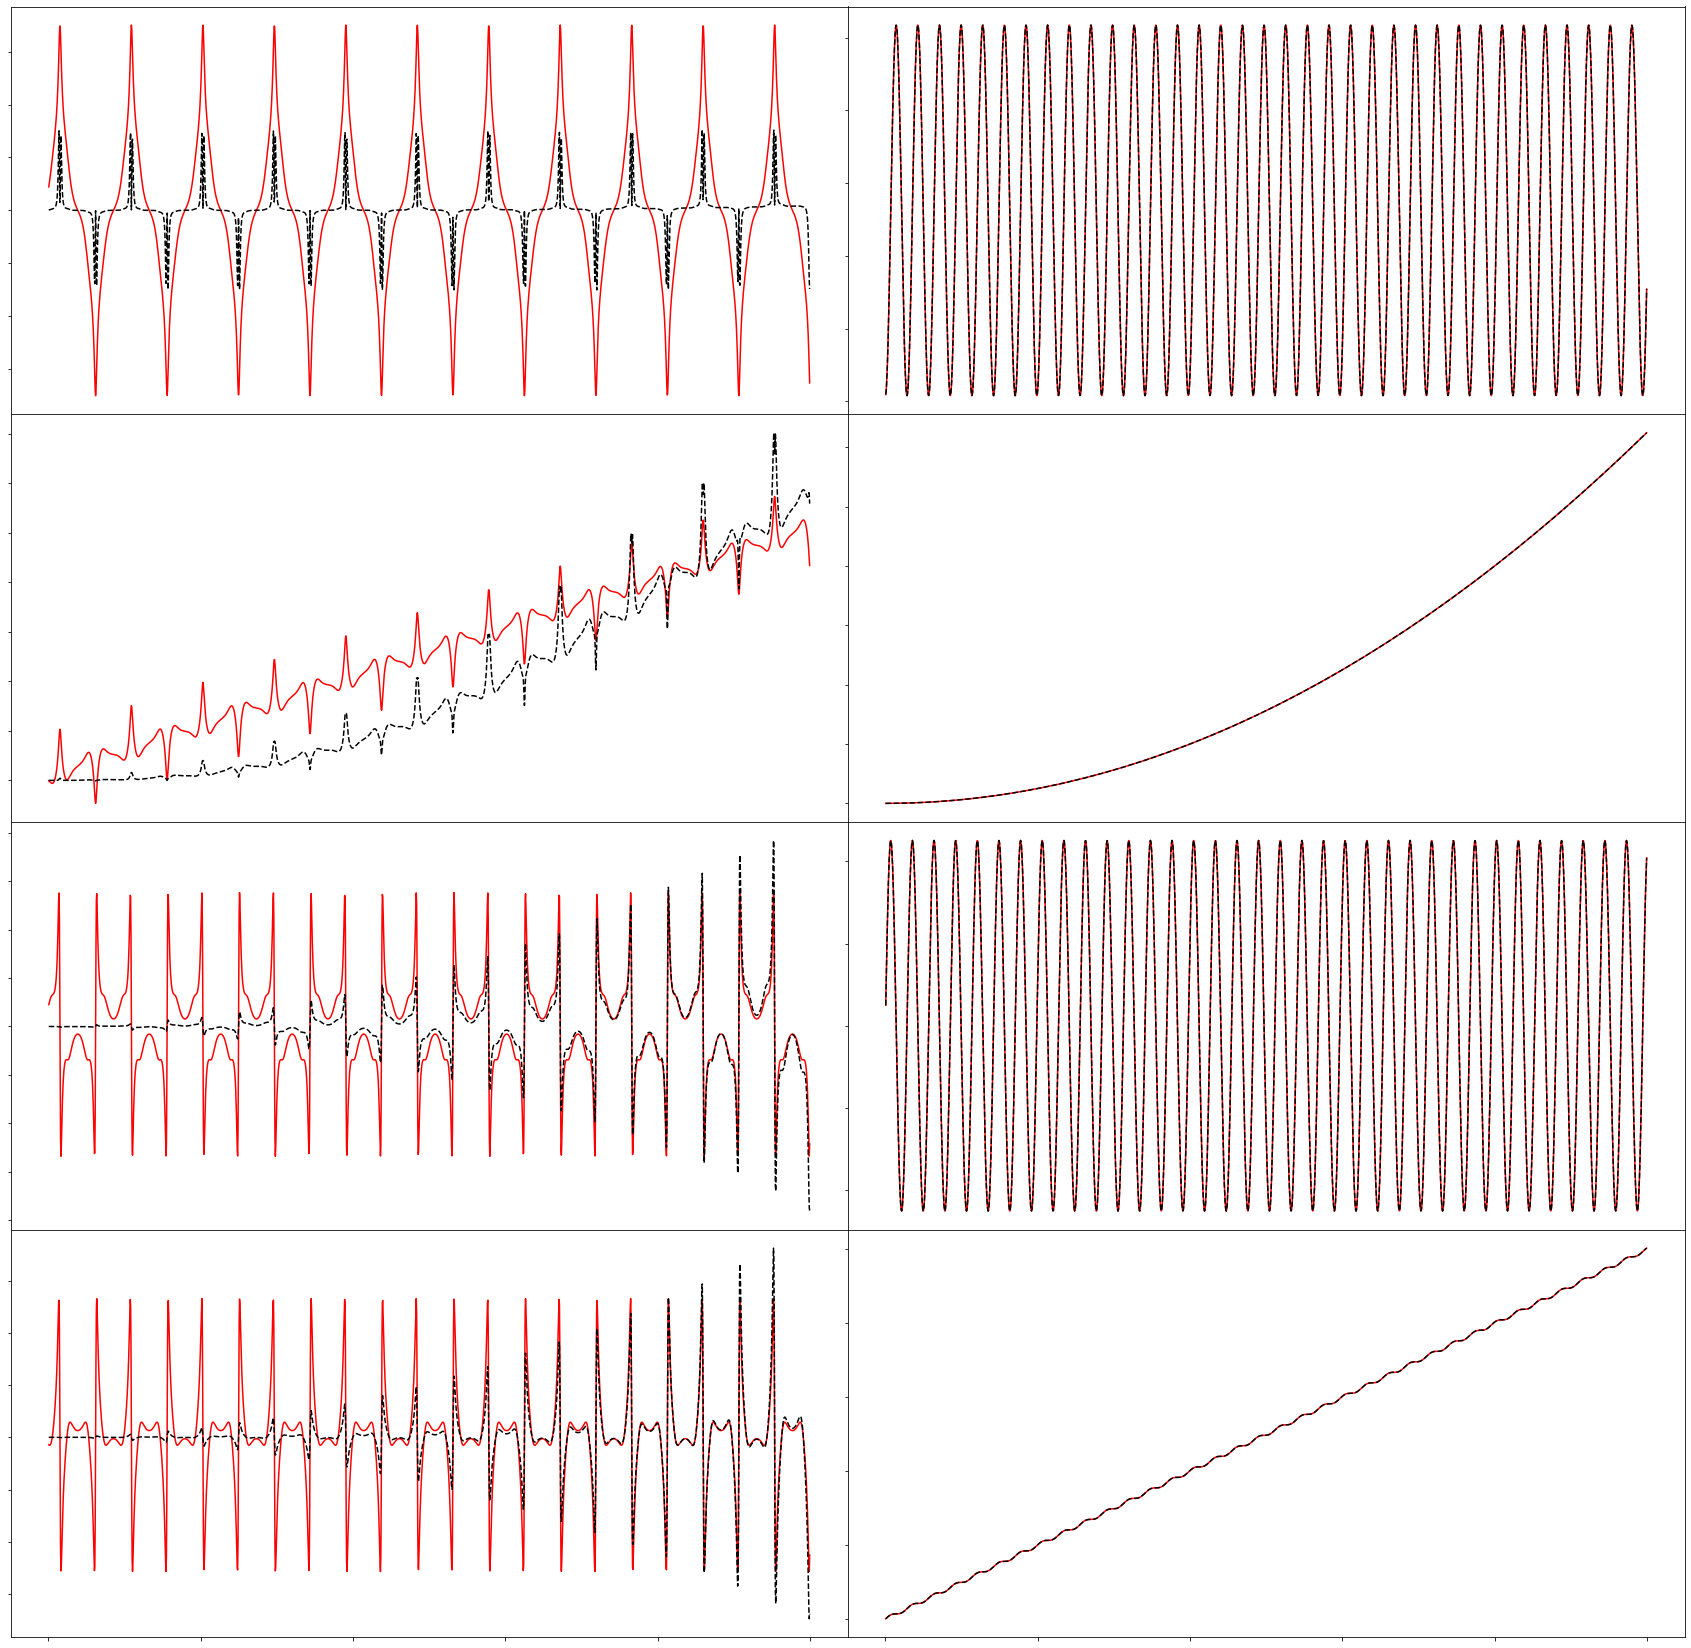

In [9]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, 1:1+r], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

[-0.3159127569508201, -0.3818665779030119, -0.8892351840235285, -0.745630043869273]
[-0.3159127569508201, -0.3818665779030119, -0.8892351840235285, -0.745630043869273]
[-3.179887179544645, -0.38186793085239584, -0.8892981929628374, -0.7456409006453768]
[-0.31591266555714387, -1.0299844772623465, -0.8892293834899039, -0.7456317246247424]
[-0.3149818829677837, -0.3818640442994747, -2.09070431940383, -0.7456327972095499]
[-0.3159174749065303, -0.3818380799869666, -0.8892643818494153, -3.181542919384325]
[0.00048283589377188396, 0.0004677682265251209, -2.8058702234304575e-05, -4.1019150100834705e-06]
[2.1714848309102212e-08, -7.701982130893783e-07, 5.1785827690153054e-09, 2.826944605259537e-09]
[-3.901108434950023e-12, 1.2683413608941188e-09, 7.500183545930347e-12, -1.791845251087883e-12]
[-3.901108434950023e-12, 1.2683413608941188e-09, 7.500183545930347e-12, -1.791845251087883e-12]
[-2.863974390715773, -1.063794417007831e-06, -5.2276897583861246e-05, -8.955038244375899e-06]
[3.28703870052

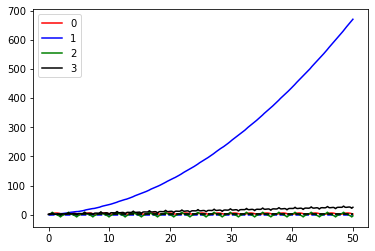

In [10]:
coef_indices = range(1, r + 1)
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 50)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)

colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart_deriv, u0, t)
for i in range(r):
    plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

du[0] -3.2332306656107872e-09
du[1] -2.683420082909374e-09
sin(u[0])*sin(u[0])*du[2]
sin(u[0])*sin(u[0])*du[3]
0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]

[1.2530393797410869e-10, 1.2215356472970948e-10, -3.2629774034390586e-08, 3.628997900250251e-06]
[-8.301638166847333e-17, 1.0805680687444242e-15, -7.941634696875342e-16, 7.476214093004577e-17]
[-2.4058265273942202e-05, 3.401007895790671e-12, -5.783421653575289e-12, 2.0857448948780705e-12]
[-2.8686191793761028e-12, 8.444201345047591e-05, -4.354493145493488e-12, 6.182792114817407e-12]
[-6.212350530866988e-12, -5.196859861261147e-12, -1.582661480369993e-07, 5.258263368900841e-10]
[6.263433080802939e-11, 6.095987627637854e-11, -1.6314948865633388e-08, 1.8144981250865105e-06]
[-1.5824977049541786e-16, 2.0598308241423355e-15, -1.5138734522052004e-15, 1.4251593745836406e-16]
[-1.2620730118484447e-05, 1.797667591198689e-12, -5.326528338319541e-12, 3.799785279582602e-12]
[-2.1747047561270697e-12, 4.4297448423696944e-05, -3.3601020856402797e-12, 3.943327051072202e-12]
[-3.2601627795044295e-12, -2.6857187108732436e-12, -8.302612901892852e-08, 2.7580522758958923e-10]
[3.283409280859892e-11, 3.1917

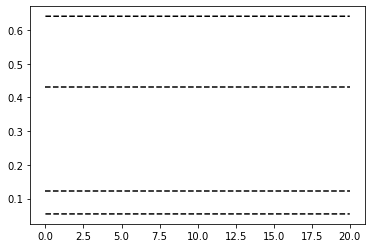

In [11]:
# These are the four coefficients we ideally want
print(feature_names[1], sindy_opt.coef_[3, 1])
print(feature_names[2], sindy_opt.coef_[4, 2])
print(feature_names[123])
print(feature_names[124])

coef_indices = [1, 2, 123, 124]
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices)
u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 20)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')
print(sol)